In [39]:
from duckduckgo_search import DDGS

from fastai.vision.all import *

import time

def search_images(keywords, max_images=200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

We're going to use Duck Duck Go search to compile images for a tool that will determine the brand of an input guitar.
<br>Best working version right now is duckduckgo_search==5.3.1b1

In [4]:
#Lets make sure that DDG is working
urls = search_images('fender electric guitar', max_images=1)
urls[0]

'https://c1.zzounds.com/media/productmedia/fit,2018by3200/quality,85/2_Body_Straight_Front_NA-39ae8c23ceaf0e68b7a3e344ea32d956.jpg'

In [40]:
#Nice, let's download the picture and check it out.
dest = 'fender.jpg'
download_url(urls[0], dest)

Path('fender.jpg')

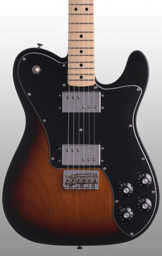

In [11]:
img = PILImage.create('fender.jpg')
img.to_thumb(256, 256)

In [ ]:
searches = 'fender', 'gibson', 'music man', 'prs', 'jackson', 'ibanez', 'dean', 'prs', 'esp'
path = Path('guitarpics')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f' {o} electric guitar'))
    time.sleep(60)
    resize_images(path/o, max_size=400, dest=path/o)

In [33]:
fns = get_image_files(path)
fns

(#1484) [Path('guitarpics/ibanez/a7f76f1c-3c1a-4c5b-b9e2-3f506c5665c1.jpg'),Path('guitarpics/ibanez/6f77642e-2c02-421d-829b-6e4979c792cb.jpg'),Path('guitarpics/ibanez/107df0eb-30f3-4ac9-a6af-744300af97f9.jpg'),Path('guitarpics/ibanez/43804dc6-e7a6-493e-a4ed-b0ec364d9efd.jpg'),Path('guitarpics/ibanez/658a57f2-e8b2-4ffb-a206-0f7a258f5b9d.jpg'),Path('guitarpics/ibanez/ce6b9de7-c767-40c0-9d74-3c563a2db12d.jpg'),Path('guitarpics/ibanez/04809fe2-cb0c-4805-9a99-4a99af668e3f.png'),Path('guitarpics/ibanez/56012b86-3344-4fa6-8cbd-11c184213ecb.jpg'),Path('guitarpics/ibanez/2003ec24-f2fe-48c0-8641-de4ae51e50d1.jpg'),Path('guitarpics/ibanez/5f9145f7-77aa-4487-967b-7880e8cf6ccd.jpg'),Path('guitarpics/ibanez/8307738f-a035-4539-89ed-b64bc20aee50.jpg'),Path('guitarpics/ibanez/db06efbc-3b10-479d-8138-045bab4ddd14.jpg'),Path('guitarpics/ibanez/416a308a-69d1-44d3-be53-840a4ba25621.jpg'),Path('guitarpics/ibanez/eae5ecff-51a9-4480-a027-216dc10ed515.jpg'),Path('guitarpics/ibanez/ff33a22d-407b-4ce6-bf2b-39d65

In [34]:
#Let's see if any are unusable
failed = verify_images(fns)
failed

(#23) [Path('guitarpics/ibanez/f29d8a1d-893d-42b3-b208-9dd31e58f2be.jpg'),Path('guitarpics/ibanez/8aa6f452-9880-4f36-ab0c-c48e1e732949.jpg'),Path('guitarpics/ibanez/120bcfbf-a143-4ab9-a8cb-7017674db2c4.jpg'),Path('guitarpics/ibanez/b16c6f01-9cee-406a-a5d3-754dfbd07d03.jpg'),Path('guitarpics/prs/472df446-d950-47a9-bf4f-c98f9b0b7624.jpg'),Path('guitarpics/prs/5e03f149-47f6-4ce9-abc4-5ba692a54f2d.jpg'),Path('guitarpics/prs/5867cdc2-340b-4c22-af75-24b42e91183b.jpg'),Path('guitarpics/prs/98384bcd-e875-476c-a313-c3a58d297ed7.jpg'),Path('guitarpics/prs/0e3534e5-4d28-4279-a1db-38538efd473f.jpg'),Path('guitarpics/prs/580999b2-2446-4f7c-8970-1592f3fc525e.jpg'),Path('guitarpics/esp/d6955d51-c1f2-449e-9e6b-5698abcea36f.jpg'),Path('guitarpics/esp/d6e4d51f-864f-43e5-849b-d0a2ef2d682d.jpg'),Path('guitarpics/esp/6f162b6a-cd4d-44e5-8d6d-00962c116513.jpg'),Path('guitarpics/esp/e39199c2-597c-4a4c-9743-ae776eef97cd.jpg'),Path('guitarpics/dean/0cd68b77-bb5c-41dc-beee-48305036235e.jpg'),Path('guitarpics/dea

In [ ]:
#for me only 23 fail, which is super acceptable considering our methods
#lets take them out of our set
#if you run this twice it errors, fyi
failed.map(Path.unlink);

In [41]:
#Making our data block
guitars = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [44]:
#passing the path to make dataloader
dls = guitars.dataloaders(path)

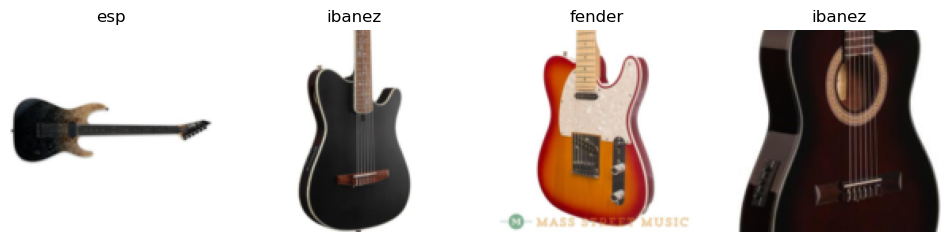

In [45]:
dls.valid.show_batch(max_n=4, nrows=1)

In [ ]:
#that's the simplest way, but let's apply some random crop/transform

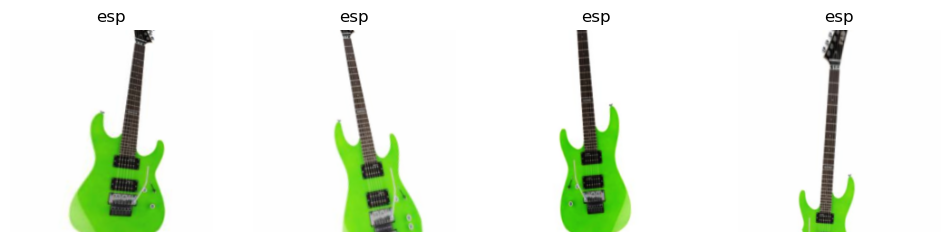

In [47]:

guitars = guitars.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = guitars.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

In the case of guitar bodies specifically I could actually see this making the model worse.
The specific curves are one of the primary ways to tell the difference for a human, but we'll see.

In [62]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,2.899461,1.639070,0.493151,00:02


epoch,train_loss,valid_loss,error_rate,time
0,1.731644,1.498392,0.448630,00:02
1,1.609122,1.432797,0.448630,00:02
2,1.421519,1.247457,0.366438,00:02
3,1.238064,1.258097,0.352740,00:02
4,1.052770,1.238555,0.335616,00:02
5,0.888273,1.249033,0.304795,00:02
6,0.751911,1.177704,0.304795,00:02
7,0.641538,1.174180,0.280822,00:04
8,0.565795,1.171798,0.284247,00:02
9,0.505445,1.179732,0.284247,00:02


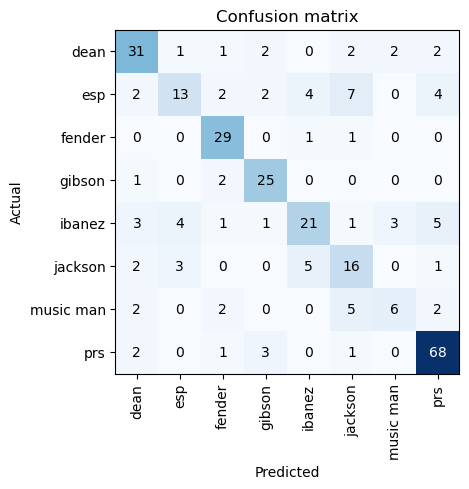

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
#let's look at how wrong we are.

Interpreting these results requires a little bit of knowlege about guitars<br>
First let's look at the most accurate category: PRS<br>
PRS guitars all look pretty much exactly the same. It makes sense that it was easy for the model to train to that.<br>
Second we have Deans which have a combination of guitars that are relatively generic looking and very unique and spiky.<br>
As we go down the list we run into brands that have a tendency to use very similar designs to one another.<br>
Music Man has many quite different looking guitars, making it hard to make a function to map them.<br>
These explanations are a little hand-wavy but I think the observations hold true.

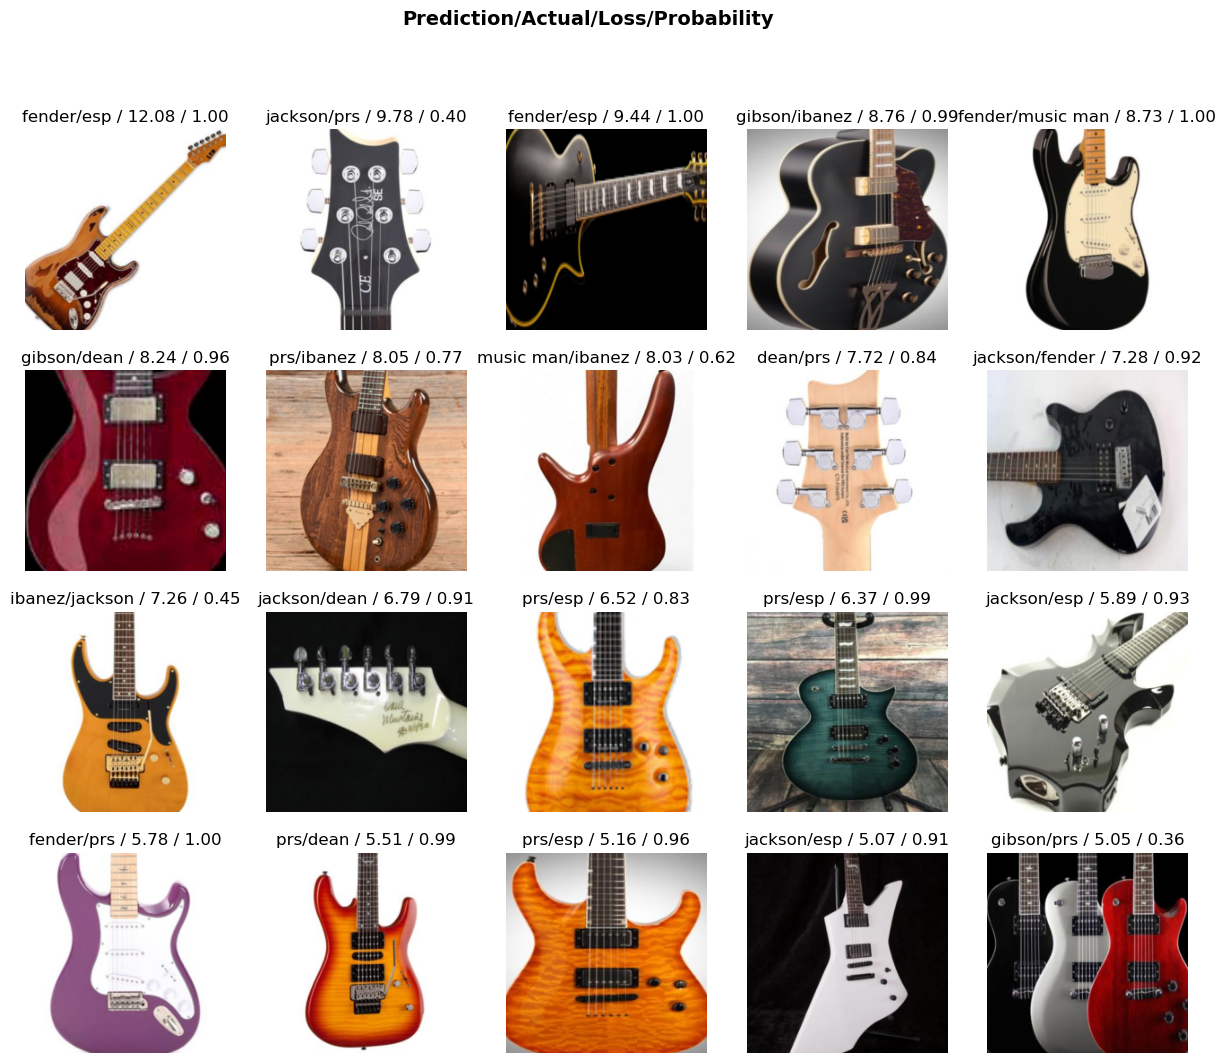

In [64]:
interp.plot_top_losses(20, nrows=4)

In [65]:
#Let's export the model for later use:
learn.export()

In [ ]:
#now let's test opening it and running a prediction on fender.jpg from earlier
learn_inf = load_learner('export.pkl')

In [67]:
learn_inf.predict('fender.jpg')

('fender',
 tensor(2),
 tensor([2.7890e-04, 2.1228e-04, 6.1931e-01, 1.1513e-03, 2.0878e-02, 8.1060e-06,
         3.5791e-01, 2.5282e-04]))

And we're done, we can use export.pkl to deploy our model on various websites.
I'm going to set up a huggingfaces space with this working.